# Linear function approximation methods for Q learning  

# Reference

Richard S. Sutton and Andrew G. Barto (2018). *Reinforcement Learning: An Introduction*. A Bradford Book, Cambridge, MA, USA.

### Modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

### Radial basis functions (RBF) for feature representation

The FeatureTransformer class is based on codes adapted from:

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl2/mountaincar/q_learning.py

https://github.com/dennybritz/reinforcement-learning

In [2]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        # sample points from observation space
        sample = np.array([env.observation_space.sample() for x in range(10000)])
        
        # Standardize features by removing the mean and scaling to unit variance
        self.scaler = StandardScaler()
        
        # Feature represetation using RBF kernels (different variances are used to cover different parts of the space)
        self.featurizer = FeatureUnion([
                                        ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                                        ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                                        ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                                        ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                                        ])     
       
        # fit transformers        
        self.scaler.fit(sample)
        self.featurizer.fit(self.scaler.transform(sample))

    def transform(self, state):
        scaled = self.scaler.transform([state])
        return self.featurizer.transform(scaled)[0]

## Section 1 On policy learning

## Episodic semi-gradient Sarsa algorithm

<img src="images/episodic-semi-gradient-sarsa.png" width=800 height=800 style="float: left"/>

### Sarsa agent

In [3]:
class SarsaAgent:

    def __init__(self, env, features):
        
        # agent's environment
        self.env = env
        
        # function encoding states to features
        self.features = features 
        
        # linear model
        self.num_actions = env.action_space.n
        num_features = len(self.features(env.observation_space.low))
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_actions, num_features))
        
        # learning parameters
        self.num_episodes = 1000
        self.epsilon = 0.1
        self.alpha = 0.01 # learning rate
        self.gamma = 0.99 # discount rate
        
        self.verbose = 200
        self.to_show = -500
        self.stats = {'rewards': []}

    def act(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        while not done:
            q_values = np.dot(self.weights, self.features(state))
            action = self.epsilon_greedy_selection(q_values, epsilon=0)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.render()
        self.env.close()
        return total_reward
            
    def epsilon_greedy_selection(self, q_values, epsilon):
        # select action
        if np.random.random() < epsilon:  # Exploration: randomly selected action
            action = np.random.randint(0, len(q_values))

        else:  # Greedy selection: action with max Q(s,a)
            q_max = np.max(q_values)
            q_max_actions = [i for i, q in enumerate(q_values) if q == q_max]
            action = q_max_actions[np.random.randint(0, len(q_max_actions))]
        return action

    def execute(self):

        # for each episode
        for episode in range(self.num_episodes):
            
            # init episode stats
            self.stats['rewards'].append(0)
            
            # get initial state
            state = self.env.reset()

            # select action based on Q(s,a) for the current state
            action = self.epsilon_greedy_selection(np.dot(self.weights, self.features(state)), self.epsilon)

            # for each time step in the episode (or until terminal state)
            while True:

                # carry out action, observe new state and reward
                new_state, reward, done, _ = self.env.step(action)
                
                # get Q(s,a) for the new state
                new_q_values = np.dot(self.weights, self.features(new_state))

                # select action for new state
                new_action = self.epsilon_greedy_selection(new_q_values, self.epsilon)

                # compute Q(s_new,a) in the new state
                if done:
                    q_new = reward
                else:
                    q_new = reward + self.gamma * new_q_values[new_action]
                    
                # get current Q(s,a)
                q_old = np.dot(self.weights, self.features(state))[action]

                # update
                self.weights[action, :] += self.alpha * (q_new - q_old) * self.features(state)

                # update episode stats
                self.stats['rewards'][-1] += reward

                # decide whether to continue episode
                if done:
                    break
                else:  # update
                    state = new_state
                    action = new_action

            # print stats on screen
            if self.verbose > 0 and episode % self.verbose == 0:
                print("episode: {}\t reward: {:.2f}".format(episode, self.stats['rewards'][-1]))
                
            # show simulated environment with learned parameters
            if self.to_show > 0 and episode % self.to_show == 0:
                self.act()

### Example

In [4]:
env = gym.make("MountainCar-v0")

transformer = FeatureTransformer(env=env, n_components=500)

agent = SarsaAgent(env=env, features=transformer.transform)
agent.execute()

episode: 0	 reward: -200.00
episode: 200	 reward: -141.00
episode: 400	 reward: -142.00
episode: 600	 reward: -144.00
episode: 800	 reward: -142.00


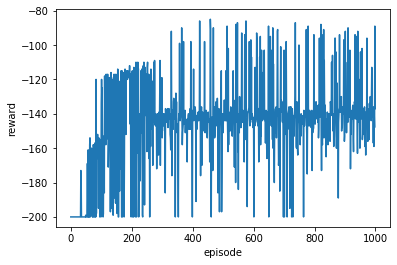

In [5]:
# plot statistics
plt.plot(agent.stats['rewards'])
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [6]:
# show agent's performance
total_reward = agent.act()

print('total_reward: %.2f' % total_reward)

total_reward: -148.00


## Section 2 Off policy learning

## Q-learning agent 

The following class provides a straightforward extension of tabular q-learning algorithm 

In [7]:
class QLearningAgent:

    def __init__(self, env, features):
        
        # agent's environment
        self.env = env
        
        # function encoding states to features
        self.features = features 
        
        # linear model
        self.num_actions = env.action_space.n
        num_features = len(self.features(env.observation_space.low))
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_actions, num_features))
        
        # learning parameters
        self.num_episodes = 1000
        self.epsilon = 0.1
        self.alpha = 0.01 # learning rate
        self.gamma = 0.99 # discount rate
        
        self.verbose = 200
        self.to_show = -500
        self.stats = {'rewards': []} 

    def act(self):
        state = self.env.reset()
        done = False
        total_reward = 0
        while not done:
            q_values = np.dot(self.weights, self.features(state))
            action = self.epsilon_greedy_selection(q_values, epsilon=0)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.render()
        self.env.close()
        return total_reward
            
    def epsilon_greedy_selection(self, q_values, epsilon):
        # select action
        if np.random.random() < epsilon:  # Exploration: randomly selected action
            action = np.random.randint(0, len(q_values))

        else:  # Greedy selection: action with max Q(s,a)
            q_max = np.max(q_values)
            q_max_actions = [i for i, q in enumerate(q_values) if q == q_max]
            action = q_max_actions[np.random.randint(0, len(q_max_actions))]
        return action

    def execute(self):

        # for each episode
        for episode in range(self.num_episodes):
            
            # init episode stats
            self.stats['rewards'].append(0)
            
            # get initial state
            state = self.env.reset()

            # for each time step in the episode (or until terminal state)
            while True:
                
                # Q(s,a) for the current state
                q_values = np.dot(self.weights, self.features(state))
                
                # select action based on Q(s,a) for the current state                
                action = self.epsilon_greedy_selection(q_values, self.epsilon)

                # carry out action, observe new state and reward
                new_state, reward, done, _ = self.env.step(action)

                # compute Q(s_new,a) in the new state
                if done:
                    q_new = reward
                else:
                    q_new = reward + self.gamma * np.max(np.dot(self.weights, self.features(new_state)))
                    
                # get current Q(s,a)
                q_old = q_values[action]

                # update
                self.weights[action, :] += self.alpha * (q_new - q_old) * self.features(state)

                # update episode stats
                self.stats['rewards'][-1] += reward

                # decide whether to continue episode
                if done:
                    break
                else:  # update
                    state = new_state

            # print stats on screen
            if self.verbose > 0 and episode % self.verbose == 0:
                print("episode: {}\t reward: {:.2f}".format(episode, self.stats['rewards'][-1]))
                
            # show simulated environment with learned parameters
            if self.to_show > 0 and episode % self.to_show == 0:
                self.act()

In [8]:
env = gym.make("MountainCar-v0")

transformer = FeatureTransformer(env=env, n_components=500)

agent = QLearningAgent(env=env, features=transformer.transform)
agent.execute()

episode: 0	 reward: -200.00
episode: 200	 reward: -191.00
episode: 400	 reward: -137.00
episode: 600	 reward: -138.00
episode: 800	 reward: -143.00


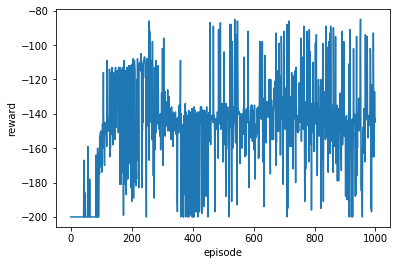

In [9]:
# plot statistics
plt.plot(agent.stats['rewards'])
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [10]:
# show agent's performance
total_reward = agent.act()

print('total_reward: %.2f' % total_reward)

total_reward: -110.00
